In [1]:
## 1. Installations & Imports
!pip install -U shap scikit-learn matplotlib seaborn numpy pandas

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from IPython.display import display

  Using cached numpy-2.2.4-cp312-cp312-win_amd64.whl.metadata (60 kB)


In [3]:
# %% [markdown]
# ## 2. Data Loading & Preprocessing
# %%
# Load dataset
try:
    df = pd.read_csv(r"C:\Users\lpath\OneDrive\Documents\kddcupdata.csv")
except FileNotFoundError:
    print("File not found. Using sample data instead.")
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=10000, n_features=41, n_classes=2, random_state=42)
    df = pd.DataFrame(X)
    df['label'] = y

# Rename columns
column_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", 
                "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", 
                "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", 
                "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", 
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
                "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", 
                "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
                "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
df.columns = column_names[:len(df.columns)]

# Convert categoricals
categorical_cols = ["protocol_type", "service", "flag"]
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category').cat.codes

# Binary labels
df['label'] = df['label'].apply(lambda x: 0 if str(x).strip() == 'normal.' else 1)

# Scale numerical features
scaler = StandardScaler()
numeric_cols = [col for col in df.columns if col not in ['label'] + categorical_cols]
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [5]:
# ## 3. Train-Test Split
# %%
X = df.drop(columns=["label"])
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = X_test[X_train.columns]  # Ensure consistent columns

print("Training shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Attack ratio:", f"{y.mean():.2%}")

# %% [markdown]

Training shape: (395216, 41)
Test shape: (98804, 41)
Attack ratio: 80.31%


Best Parameters: {'max_depth': None, 'n_estimators': 100}
CV Accuracy: 0.9998 (±0.0001)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19368
           1       1.00      1.00      1.00     79436

    accuracy                           1.00     98804
   macro avg       1.00      1.00      1.00     98804
weighted avg       1.00      1.00      1.00     98804



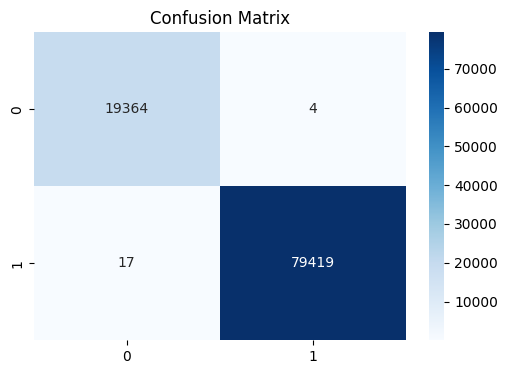

In [7]:
# ## 4. Random Forest Classifier
# %%
# Hyperparameter Tuning

param_grid = {'n_estimators': [100], 'max_depth': [10, None]}  # Fewer options

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"CV Accuracy: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

# Evaluation
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

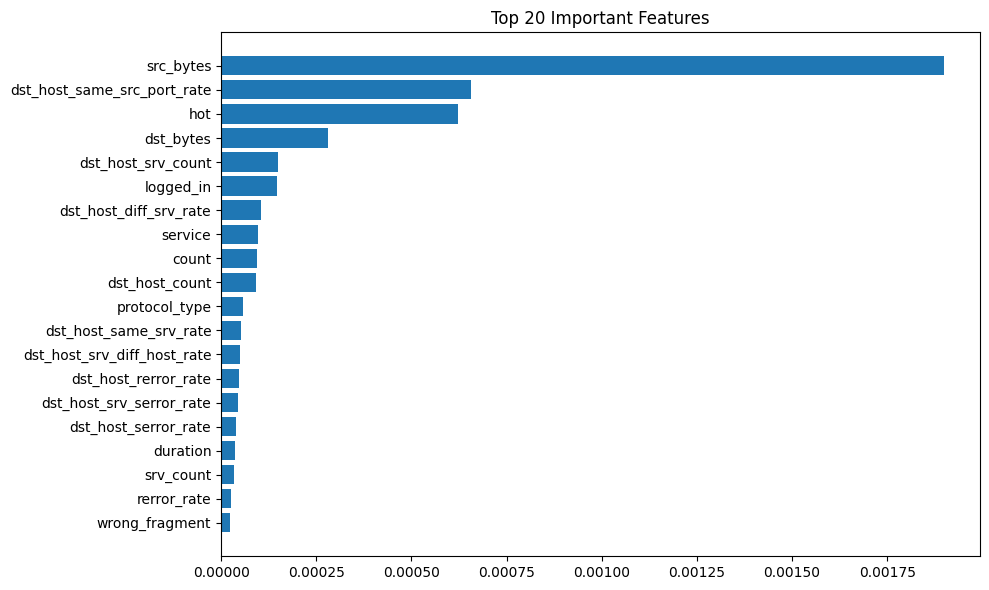

In [9]:
# ## 5. Feature Importance
# %%
# Permutation Importance
result = permutation_importance(best_model, X_test, y_test, n_repeats=5, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.barh(X.columns[sorted_idx[-20:]], result.importances_mean[sorted_idx[-20:]])
plt.title("Top 20 Important Features")
plt.tight_layout()
plt.show()

# %% [markdown]

Using contamination: 0.5000

Isolation Forest Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19368
           1       0.60      0.36      0.45     79436

    accuracy                           0.29     98804
   macro avg       0.30      0.18      0.22     98804
weighted avg       0.48      0.29      0.36     98804



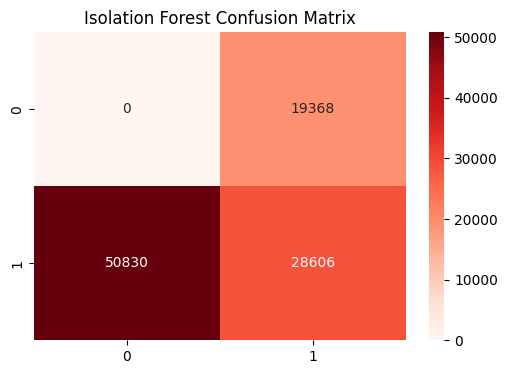

In [10]:
# ## 6. Isolation Forest (Anomaly Detection) - FIXED
# %%
# Calculate safe contamination value (max 0.5)
contamination = max(0.01, min(0.5, y_train.mean())) # Cap at 0.5 if attack ratio is higher
print(f"Using contamination: {contamination:.4f}")
  # Ensures it’s at least 1%

iso_forest = IsolationForest(
    contamination=contamination,
    random_state=42,
    n_jobs=-1
)
iso_forest.fit(X_train)

iso_preds = np.where(iso_forest.predict(X_test) == -1, 1, 0)
print("\nIsolation Forest Report:")
print(classification_report(y_test, iso_preds))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, iso_preds), annot=True, fmt='d', cmap='Reds')
plt.title("Isolation Forest Confusion Matrix")
plt.show()

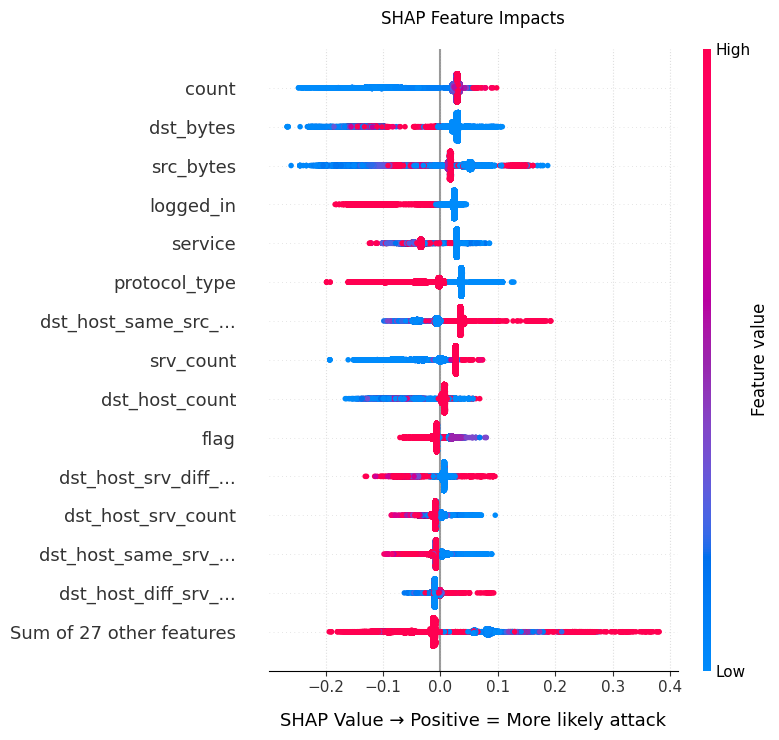

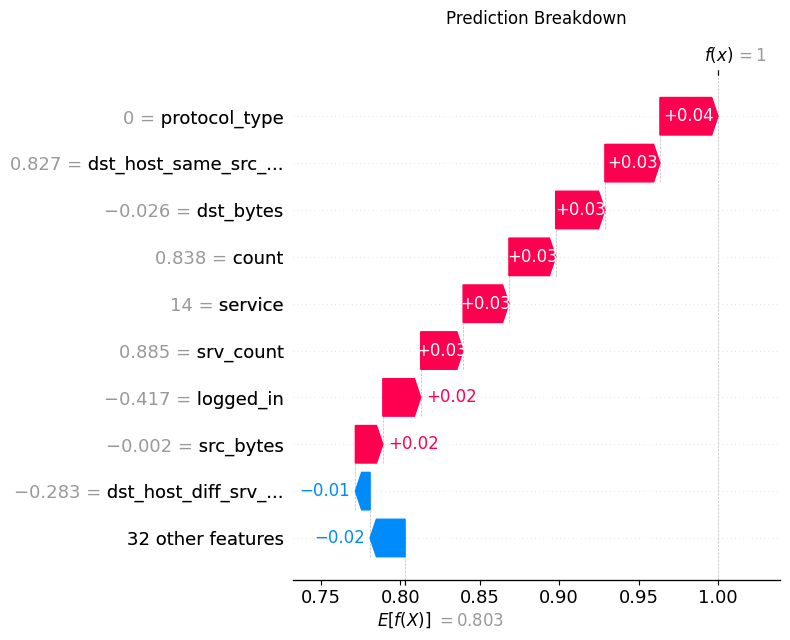


🔍 Top Predictive Features:


,Feature,SHAP Value,Raw Value
1,protocol_type,0.036600,0.000000
35,dst_host_same_src_...,0.034700,0.830000
5,dst_bytes,0.031000,-0.030000
22,count,0.029500,0.840000
2,service,0.028900,14.000000
23,srv_count,0.026700,0.890000
11,logged_in,0.023900,-0.420000
4,src_bytes,0.017300,-0.000000
34,dst_host_diff_srv_...,-0.009300,-0.280000
32,dst_host_srv_count,-0.008600,0.630000


In [21]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import shap
import pandas as pd
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# 1. Configure global settings
rcParams.update({
    'figure.titlesize': 14,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'font.family': 'DejaVu Sans',
    'figure.facecolor': 'white'
})

# 2. Initialize SHAP and create sample data
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)

# Handle binary classification
if len(shap_values.shape) == 3:  # (n_samples, n_features, n_classes)
    shap_values_attack = shap_values[..., 1]  # Attack class
else:
    shap_values_attack = shap_values

# Create sample data (replace with your actual sampling if needed)
X_sample = X_test.sample(min(100, len(X_test)), random_state=42)

# 3. Prepare feature names
feature_names = [f[:18] + ('...' if len(f) > 18 else '') for f in X_train.columns]
shap_values_attack.feature_names = feature_names

# 4. Robust Beeswarm Plot
fig, ax = plt.subplots(figsize=(14, 9))
shap.plots.beeswarm(
    shap_values_attack,
    max_display=15,
    show=False  # Remove color parameter for stability
)
ax.set_title("SHAP Feature Impacts", pad=18)
ax.set_xlabel("SHAP Value → Positive = More likely attack", labelpad=12)
ax.grid(True, axis='x', linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()

# 5. Waterfall Plot with Fallback
try:
    plt.figure(figsize=(16, 6))
    shap.plots.waterfall(shap_values_attack[0], max_display=10, show=False)
    plt.title("Prediction Breakdown", pad=15)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Waterfall failed: {str(e)}")
    shap.initjs()
    display(shap.plots.force(
        explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
        shap_values_attack[0].values,
        X_test.iloc[0]  # Using X_test instead of X_sample
    ))

# 6. Feature Diagnostics
print("\n🔍 Top Predictive Features:")
display(pd.DataFrame({
    'Feature': feature_names,
    'SHAP Value': shap_values_attack[0].values.round(4),
    'Raw Value': X_test.iloc[0].values.round(2)  # Using X_test
}).sort_values('SHAP Value', key=abs, ascending=False).head(10).style
    .bar(color='#FFA07A', subset=['SHAP Value'])
    .bar(color='#ADD8E6', subset=['Raw Value']))